## Includes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import glob
from einops import rearrange
from box import Box

# Latex results

In [2]:
results = [pd.read_csv(path) for path in glob.glob("../../logs/*csv")]
print(len(results))
results = pd.concat(results)
# Clean dataframe
results = results.apply(lambda x: x.apply(lambda y: y.split(' ')[1][:-1]))
results

1293


,eeg_feature,model,hidden_channels,window_size,batch_size,learning_rate,dropout_rate,weight_decay,activation_funct,number_train_samples,...,val_f1,val_prec,val_reca,val_roc,pytorch_total_params,train_time,best_epoch,experiment_id,train_samples,val_samples
0,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8522854690426398,0.872042692918295,0.8603125,0.9867886088709676,16677,3358.1363031864166,1109,'28','349,'342
1,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8322322273253404,0.8401366979143605,0.84375,0.983835181451613,16677,1589.5292069911957,437,'1168','151,'271
2,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.7709894893373543,0.7875152875678328,0.776875,0.982107258064516,16677,2573.179792165756,776,'2308','855,'858
3,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8682450705841627,0.8704146612839095,0.8771875,0.9934779233870967,16677,1182.5789799690247,363,'3448','416,'762
4,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8561750756522502,0.8602070431385651,0.8678125000000001,0.98903125,16677,3261.1691002845764,1057,'4588','88,'469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.27963438316453837,0.3813149285106948,0.251875,0.6156347782258065,8417,2006.3740091323853,572,'6563','156,'230
6,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.27749503224576694,0.3898024719547163,0.2578125,0.6127298387096773,8417,1397.7262737751007,352,'8843','373,'281
7,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.307950082333493,0.4474532603764968,0.29500000000000004,0.6686327620967742,8417,1193.5467810630798,290,'9983','252,'364
8,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.23761364063347176,0.3403170651814279,0.22093749999999998,0.6038013104838711,8417,1500.0500242710114,396,'11123','27,'298


In [3]:
model_names = ['LR','MLP','CNN','GraphConv']
hidden_channels = [64, 128, 256, 512, 1024, 2048]
models = list(filter(None, [f'{name}_{hc}' if not name == 'LR' else None if hc != 64 else 'LR' for name in model_names for hc in hidden_channels ]))
features = ['wav','psd','raw']
window_sizes = [0.25, 0.5, 1, 1.5, 2]
number_train_samples = [1, 2, 4, 8]

In [4]:
sorted_by_time_nts_ws = np.array([ws*nts for ws in window_sizes for nts in number_train_samples])
b = np.array([ws for ws in window_sizes for nts in number_train_samples])
c = np.array([nts for ws in window_sizes for nts in number_train_samples])
idx = np.argsort(sorted_by_time_nts_ws)
sorted_by_time_nts_ws.sort()
sorted_ws = b[idx]
sorted_nts = c[idx]

In [5]:
dfs = []

for ef in features:
    print(ef)
    df = pd.DataFrame(index=models)
    for (ws,nts) in zip(sorted_ws, sorted_nts):
        res_col = []
        for model in models:
            if model == 'LR':
                hc = 0
            else:
                model, hc = model.split('_')
                hc = int(hc)
            res = results[(results['model'] == f'\'{model}\'') & (results['hidden_channels'].astype(int)==hc) & (results['window_size'].astype(float) == ws) & (results['number_train_samples'].astype(int)==nts) & (results['eeg_feature'] == f'\'{ef}\'')]
            mean_acc = res['test_acc'].astype(float).mean()
            std_acc = res['test_acc'].astype(float).std()

            res_col.append(f'{mean_acc:.2f}±{std_acc:.2f}')
        df[f'{ef} {ws}s x{nts}'] = res_col  
    dfs.append(df)

wav
psd
raw


In [6]:
wav_df, psd_df, raw_df = dfs[0], dfs[1], dfs[2]

# Inflection points

In [7]:
lr_res = wav_df.iloc[0]
lr_res

wav 0.25s x1    0.78±0.03
wav 0.25s x2    0.87±0.02
wav 0.5s x1     0.85±0.03
wav 0.25s x4    0.93±0.01
wav 0.5s x2     0.93±0.01
wav 1.0s x1     0.91±0.01
wav 1.5s x1     0.93±0.03
wav 2.0s x1     0.95±0.01
wav 1.0s x2     0.96±0.01
wav 0.5s x4     0.97±0.01
wav 0.25s x8    0.96±0.00
wav 1.5s x2     0.98±0.00
wav 1.0s x4     0.99±0.00
wav 2.0s x2     0.98±0.01
wav 0.5s x8     0.98±0.00
wav 1.5s x4     0.99±0.00
wav 2.0s x4     0.99±0.00
wav 1.0s x8     0.99±0.00
wav 1.5s x8     1.00±0.00
wav 2.0s x8     1.00±0.00
Name: LR, dtype: object

## Option 1) Show all values

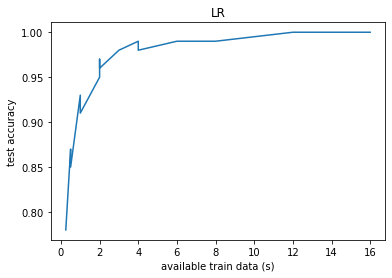

In [8]:
lr_means = np.array([float(x.split('±')[0]) for x in lr_res.to_numpy()])
lr_stds = np.array([float(x.split('±')[1]) for x in lr_res.to_numpy()])
plt.plot(sorted_by_time_nts_ws,lr_means)
plt.title('LR')
plt.xlabel('available train data (s)')
plt.ylabel('test accuracy')
plt.show()

## Option 2) Merge values for x
https://www.researchgate.net/post/How_do_I_combine_mean_and_standard_deviation_of_two_groups

In [9]:
u_sorted_by_time_nts_ws = np.unique(sorted_by_time_nts_ws)
u_sorted_by_time_nts_ws

array([ 0.25,  0.5 ,  1.  ,  1.5 ,  2.  ,  3.  ,  4.  ,  6.  ,  8.  ,
       12.  , 16.  ])

In [10]:
merged_lr_res = []
for t in u_sorted_by_time_nts_ws:
    lr_res_time = lr_res[sorted_by_time_nts_ws==t]
    means = np.array([float(x.split('±')[0]) for x in lr_res_time.to_numpy()])
    stds = np.array([float(x.split('±')[1]) for x in lr_res_time.to_numpy()])
    merged_lr_res.append(f'{means.mean():.2f}±{stds.mean():.2f}')
merged_lr_res = pd.Series(data=merged_lr_res, index=u_sorted_by_time_nts_ws)
merged_lr_res

0.25     0.78±0.03
0.50     0.86±0.03
1.00     0.92±0.01
1.50     0.93±0.03
2.00     0.96±0.01
3.00     0.98±0.00
4.00     0.98±0.00
6.00     0.99±0.00
8.00     0.99±0.00
12.00    1.00±0.00
16.00    1.00±0.00
dtype: object

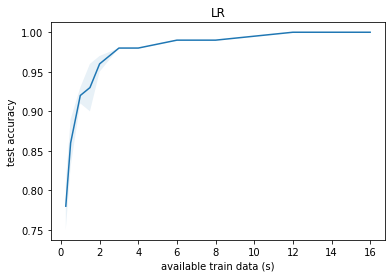

In [11]:
lr_means = np.array([float(x.split('±')[0]) for x in merged_lr_res.to_numpy()])
lr_stds = np.array([float(x.split('±')[1]) for x in merged_lr_res.to_numpy()])
plt.plot(u_sorted_by_time_nts_ws,lr_means)
plt.fill_between(u_sorted_by_time_nts_ws,lr_means-lr_stds,lr_means+lr_stds,alpha=.1)
plt.title('LR')
plt.xlabel('available train data (s)')
plt.ylabel('test accuracy')
plt.show()

# Create merged dfs

In [12]:
merged_dfs = []
for i,df in enumerate(dfs):
    merged_df_rows = []
    for row_id in range(len(df)):
        row_res = df.iloc[row_id]
        merged_row_res = []
        for t in u_sorted_by_time_nts_ws:
            raw_res_time = row_res[sorted_by_time_nts_ws==t]
            means = np.array([float(x.split('±')[0]) for x in raw_res_time.to_numpy()])
            stds = np.array([float(x.split('±')[1]) for x in raw_res_time.to_numpy()])
            merged_row_res.append(f'{means.mean():.2f}±{stds.mean():.2f}')
        # merged_row_res = pd.Series(data=merged_row_res, index=u_sorted_by_time_nts_ws)
        merged_df_rows.append(merged_row_res)
    merged_dfs.append(pd.DataFrame(merged_df_rows,index=models,columns=[f'{features[i]} {t} s.' for t in u_sorted_by_time_nts_ws]))

In [13]:
merged_wav_df, merged_psd_df, merged_raw_df = merged_dfs[0], merged_dfs[1], merged_dfs[2]

In [14]:
merged_wav_df

,wav 0.25 s.,wav 0.5 s.,wav 1.0 s.,wav 1.5 s.,wav 2.0 s.,wav 3.0 s.,wav 4.0 s.,wav 6.0 s.,wav 8.0 s.,wav 12.0 s.,wav 16.0 s.
LR,0.78±0.03,0.86±0.03,0.92±0.01,0.93±0.03,0.96±0.01,0.98±0.00,0.98±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_64,0.80±0.03,0.87±0.01,0.93±0.01,0.93±0.03,0.96±0.01,0.98±0.01,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_128,0.81±0.02,0.88±0.01,0.93±0.01,0.94±0.03,0.97±0.01,0.99±0.00,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_256,0.82±0.03,0.89±0.01,0.94±0.01,0.94±0.02,0.97±0.01,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00
MLP_512,0.82±0.03,0.89±0.01,0.94±0.01,0.94±0.02,0.97±0.01,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00
MLP_1024,0.82±0.03,0.89±0.01,0.94±0.01,0.94±0.02,0.97±0.01,0.99±0.01,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00
MLP_2048,0.82±0.03,0.89±0.01,0.94±0.01,0.94±0.02,0.97±0.01,0.99±0.01,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00
CNN_64,0.73±0.09,0.76±0.14,0.88±0.05,0.73±0.37,0.90±0.10,0.93±0.04,0.97±0.01,0.97±0.03,0.97±0.03,0.98±0.01,0.99±0.00
CNN_128,0.64±0.23,0.75±0.16,0.85±0.12,0.88±0.04,0.90±0.16,0.96±0.02,0.96±0.05,0.99±0.01,0.99±0.01,0.98±0.02,0.99±0.01
CNN_256,0.60±0.24,0.70±0.25,0.76±0.22,0.76±0.27,0.92±0.06,0.95±0.03,0.96±0.04,0.89±0.30,0.98±0.01,0.99±0.01,0.99±0.00


# Create latex tables for merged results

In [15]:
for i,f in enumerate(features):
    text_file = open(f'tables/{f}_table_res_merged.tex', "w")
    n = text_file.write(merged_dfs[i].to_latex(bold_rows=True))
    text_file.close()

# Plot both options side by side

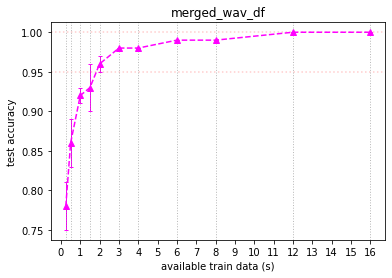

In [143]:
def show_inflection_point_graph(model_name, df, title, show_grid=True,color='#ff00ff',label=''):
    model_idx = np.where(df.index.to_numpy()==model_name)[0][0]
    res = df.iloc[model_idx]
    means = np.array([float(x.split('±')[0]) for x in res.to_numpy()])
    stds = np.array([float(x.split('±')[1]) for x in res.to_numpy()])
    x_axis = u_sorted_by_time_nts_ws if df.shape[1] == 11 else sorted_by_time_nts_ws
    n_secs = int(x_axis.max()+1)
    plt.errorbar(x_axis, means, stds, linestyle='--', marker='^',ecolor=color,elinewidth=1,capsize=2,color=color, label=label)
    if show_grid:
        plt.axhline(1, color='red',alpha=0.2,linestyle=':')
        plt.axhline(.95, color='red',alpha=0.2,linestyle=':')
    plt.xticks(list(range(n_secs)))
    for i in np.arange(0,n_secs,0.25):
#         if int(i) == i:
#             plt.axvline(i, color='gray',alpha=0.25,linestyle=':')
        if show_grid and i in x_axis:
            plt.axvline(i, color='gray',alpha=0.55,linestyle=':',linewidth=1)
    
    plt.title(f'{title}')
    plt.xlabel('available train data (s)')
    plt.ylabel('test accuracy')

show_inflection_point_graph(models[0], merged_wav_df, 'merged_wav_df')

<ipython-input-91-b58e771a68d9>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 4, 1+j)
<ipython-input-91-b58e771a68d9>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 4, 5+j)


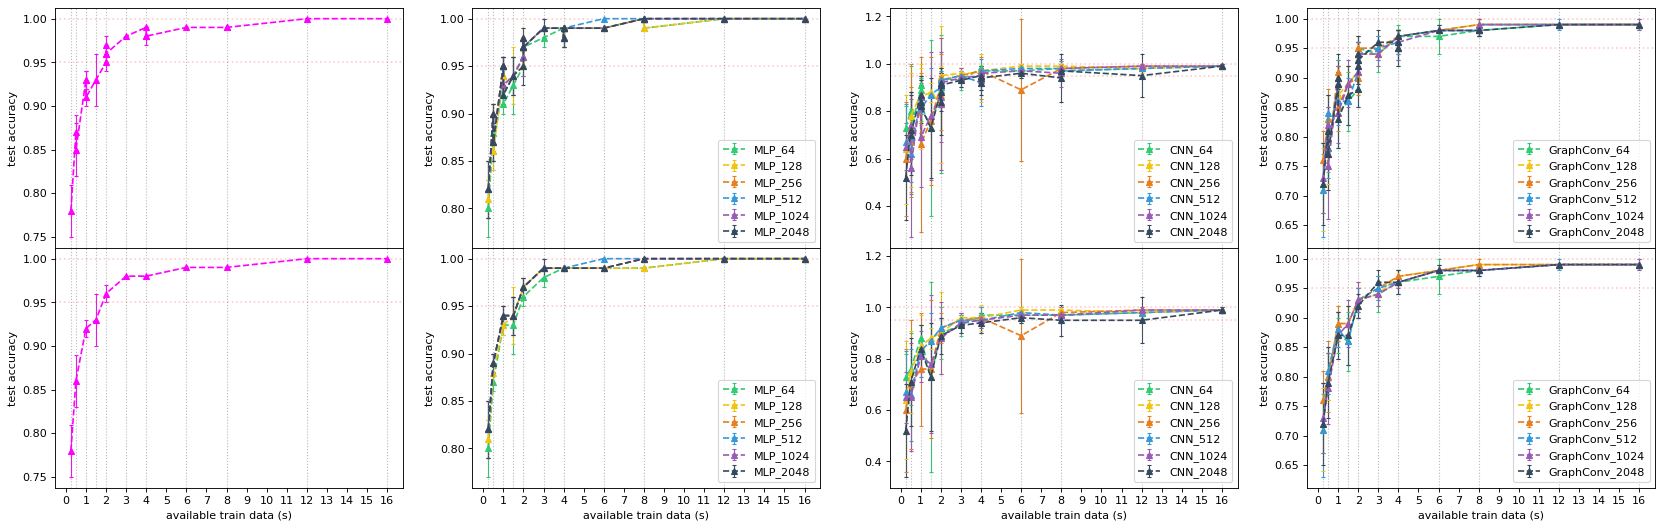

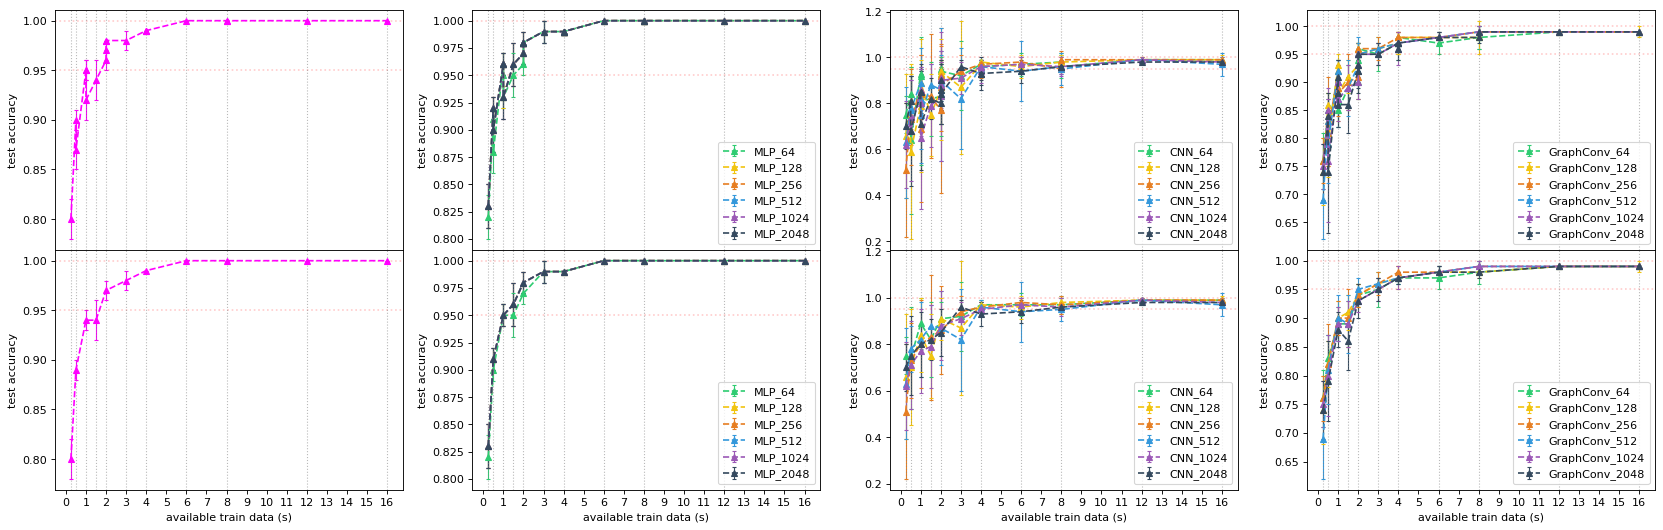

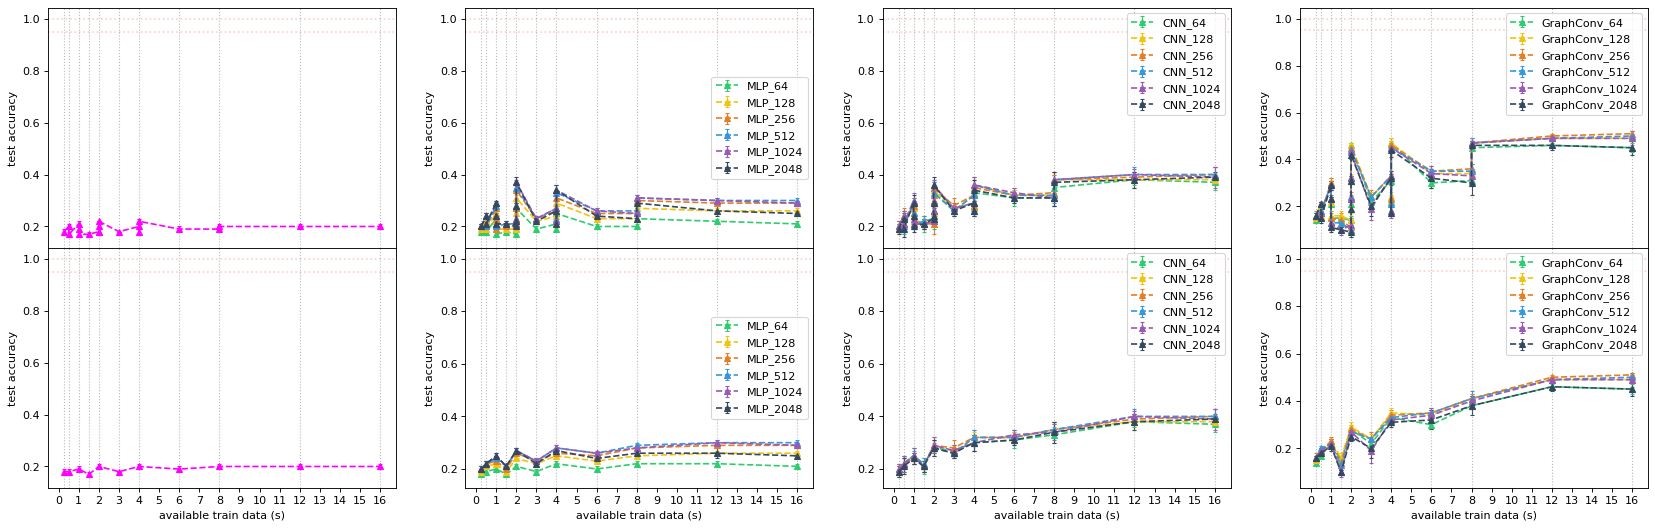

In [91]:
from matplotlib.pyplot import figure
colors = ['#2ecc71','#f1c40f','#e67e22','#3498db','#9b59b6','#34495e']
for i, (df,merged_df) in enumerate(zip(dfs,merged_dfs)):
    figure(figsize=(20, 6), dpi=80)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.2, hspace=0)
    for j, name in enumerate(model_names):
        if name =='LR':
            plt.subplot(2, 4, 1)
            show_inflection_point_graph(name, df, f'{name}({features[i]})')
            plt.subplot(2, 4, 5)
            show_inflection_point_graph(name, merged_df, f'{name} ({features[i]}) merged')
            continue
        for k, hc in enumerate(hidden_channels):
            plt.subplot(2, 4, 1+j)
            show_inflection_point_graph(f'{name}_{hc}', df, f'{name}({features[i]})',show_grid = True if k ==0 else False,color=colors[k],label=f'{name}_{hc}')
            plt.legend()
            plt.subplot(2, 4, 5+j)
            show_inflection_point_graph(f'{name}_{hc}', merged_df, f'{name} ({features[i]}) merged',show_grid = True if k ==0 else False,color=colors[k],label=f'{name}_{hc}')
            plt.legend()
    plt.show()

In [92]:
# # %%capture
# from matplotlib.pyplot import figure
# for i, (df,merged_df) in enumerate(zip(dfs,merged_dfs)):
#     for model in models:
#         figure(figsize=(20, 6), dpi=80)
#         plt.subplot(1, 2, 1)
#         show_inflection_point_graph(model, df, f'{model}({features[i]})')
#         plt.subplot(1, 2, 2)
#         show_inflection_point_graph(model, merged_df, f'{model} ({features[i]}) merged')
# #         plt.savefig(f'figures/{features[i]}_{model}.png')
#         plt.show()

## Window size vs nts. Is it better to have more, smaller windows or fewer bigger ones?

In [66]:
# Define what to pick from results
window_sizes = [0.25, 0.5, 1, 1.5, 2]
number_train_samples = [1, 2, 4, 8]

In [67]:
sorted_time_combinations = np.array([ws*nts for ws in window_sizes for nts in number_train_samples])
windows = np.array([ws for ws in window_sizes for nts in number_train_samples])
samples = np.array([nts for ws in window_sizes for nts in number_train_samples])
idx = np.argsort(sorted_time_combinations)
sorted_time_combinations.sort()
sorted_ws = windows[idx]
sorted_nts = samples[idx]

In [68]:
sorted_time_combinations

array([ 0.25,  0.5 ,  0.5 ,  1.  ,  1.  ,  1.  ,  1.5 ,  2.  ,  2.  ,
        2.  ,  2.  ,  3.  ,  4.  ,  4.  ,  4.  ,  6.  ,  8.  ,  8.  ,
       12.  , 16.  ])

In [69]:
repeated_times = []
for unique_time in np.unique(sorted_time_combinations):
    if len(np.where(sorted_time_combinations==unique_time)[0])>1:
        repeated_times.append(unique_time)
repeated_times

[0.5, 1.0, 2.0, 4.0, 8.0]

In [70]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [71]:
col_idx_names = []
for repeated in repeated_times:
    indices = np.where(sorted_time_combinations==repeated)
    number_train_samples = sorted_nts[indices]
    window_sizes = sorted_ws[indices]
    idx = np.argsort(window_sizes)
    window_sizes = window_sizes[idx]
    number_train_samples = number_train_samples[idx]
    for i,(nts,ws) in enumerate(zip(number_train_samples,window_sizes)):
        col_idx_names.append(f'{nts} x {ws}')
blank_col = ['' for i in range(len(col_idx_names))]
columns = {}
for col_name in col_idx_names:
    columns[f'{col_name}'] = blank_col
t_test_df = pd.DataFrame(columns,index = col_idx_names)

In [72]:
for repeated in repeated_times:
    indices = np.where(sorted_time_combinations==repeated)
    number_train_samples = sorted_nts[indices]
    window_sizes = sorted_ws[indices]
    idx = np.argsort(window_sizes)
    all_ef_accs = []
    for ef in features:
        accs = []
        for i,(nts,ws) in enumerate(zip(number_train_samples,window_sizes)):
            test_accs = results[(results['window_size'].astype(float) == ws) & (results['number_train_samples'].astype(int)==nts)  & (results['eeg_feature'] == f'\'{ef}\'')]['test_acc'].to_numpy().astype(float)
            print(f'({i})Total time ({ef}): {repeated} nts:({nts}) ws:({ws}) Test accuracy:{test_accs.mean():.2f}±{test_accs.std():.2f} N:{len(test_accs)}')
            accs.append(test_accs)
        all_ef_accs.append(accs)
        accs= np.array(accs)
        for i in range(len(accs)):
            for j in range(0,len(accs)):
                if i !=j:
                    ttest = stats.ttest_ind(accs[i],accs[j])
                    print('+++++',f'T-test {i}-{j}', f'{bcolors.OKGREEN if ttest.pvalue < 0.01 else bcolors.WARNING if ttest.pvalue < 0.05 else bcolors.FAIL }p-val: {ttest.pvalue:.3f}{bcolors.ENDC}'
                          , f'{bcolors.OKGREEN if ttest.statistic > 0 else bcolors.FAIL}statistic: {ttest.statistic:.3f}{bcolors.ENDC}')
    all_ef_accs = np.array(all_ef_accs)
    all_ef_accs = rearrange(all_ef_accs,'a b c -> b (a c)')
    print(f"{bcolors.HEADER}//////COMBINED EF/////////{bcolors.ENDC}")
    for i in range(len(all_ef_accs)):
        for j in range(0,len(all_ef_accs)):
            if i !=j:
                ttest = stats.ttest_ind(all_ef_accs[i],all_ef_accs[j])
                name1 = f'{number_train_samples[i]} x {window_sizes[i]}'
                name2 = f'{number_train_samples[j]} x {window_sizes[j]}'
                t_test_df[name2][name1] = f'{ttest.statistic:.3f} {"***" if ttest.pvalue < 0.01 else "**" if ttest.pvalue < 0.05 else "*" if ttest.pvalue < 0.1 else "" }'
                print('+++++',f'T-test {i}-{j}', f'{bcolors.OKGREEN if ttest.pvalue < 0.01 else bcolors.WARNING if ttest.pvalue < 0.05 else bcolors.FAIL }p-val: {ttest.pvalue:.3f}{bcolors.ENDC}'
                      , f'{bcolors.OKGREEN if ttest.statistic > 0 else bcolors.FAIL}statistic: {ttest.statistic:.3f}{bcolors.ENDC}')
    print(f"{bcolors.HEADER}///////////////{bcolors.ENDC}")

(0)Total time (wav): 0.5 nts:(2) ws:(0.25) Test accuracy:0.82±0.13 N:190
(1)Total time (wav): 0.5 nts:(1) ws:(0.5) Test accuracy:0.78±0.14 N:190
+++++ T-test 0-1 p-val: 0.001 statistic: 3.207
+++++ T-test 1-0 p-val: 0.001 statistic: -3.207
(0)Total time (psd): 0.5 nts:(2) ws:(0.25) Test accuracy:0.85±0.10 N:190
(1)Total time (psd): 0.5 nts:(1) ws:(0.5) Test accuracy:0.79±0.17 N:190
+++++ T-test 0-1 p-val: 0.000 statistic: 4.340
+++++ T-test 1-0 p-val: 0.000 statistic: -4.340
(0)Total time (raw): 0.5 nts:(2) ws:(0.25) Test accuracy:0.22±0.02 N:190
(1)Total time (raw): 0.5 nts:(1) ws:(0.5) Test accuracy:0.19±0.03 N:190
+++++ T-test 0-1 p-val: 0.000 statistic: 14.636
+++++ T-test 1-0 p-val: 0.000 statistic: -14.636
//////COMBINED EF/////////
+++++ T-test 0-1 p-val: 0.009 statistic: 2.618
+++++ T-test 1-0 p-val: 0.009 statistic: -2.618
///////////////
(0)Total time (wav): 1.0 nts:(4) ws:(0.25) Test accuracy:0.90±0.06 N:190
(1)Total time (wav): 1.0 nts:(2) ws:(0.5) Test accuracy:0.90±0.08 N

In [73]:
t_test_df

,2 x 0.25,1 x 0.5,4 x 0.25,2 x 0.5,1 x 1.0,8 x 0.25,4 x 0.5,2 x 1.0,1 x 2.0,8 x 0.5,4 x 1.0,2 x 2.0,8 x 1.0,4 x 2.0
2 x 0.25,,2.618 ***,,,,,,,,,,,,
1 x 0.5,-2.618 ***,,,,,,,,,,,,,
4 x 0.25,,,,1.425,3.584 ***,,,,,,,,,
2 x 0.5,,,-1.425,,2.123 **,,,,,,,,,
1 x 1.0,,,-3.584 ***,-2.123 **,,,,,,,,,,
8 x 0.25,,,,,,,1.514,3.065 ***,4.629 ***,,,,,
4 x 0.5,,,,,,-1.514,,1.532,3.062 ***,,,,,
2 x 1.0,,,,,,-3.065 ***,-1.532,,1.516,,,,,
1 x 2.0,,,,,,-4.629 ***,-3.062 ***,-1.516,,,,,,
8 x 0.5,,,,,,,,,,,1.453,2.705 ***,,


According to these results there is a positive statistically significance difference for the test accuracy between the distributions that used more, smaller training epochs and those that used more, bigger epochs. Suggesting getting different samples for different videos is more effective than picking it all at once.

### Create best epoch configuration dfs (smaller epochs, more samples) -> 2 x 0.25, 4 x 0.25, 8 x 0.25, 8 x 0.5, 8 x 1.0

In [74]:
u_sorted_by_time_nts_ws

array([ 0.25,  0.5 ,  1.  ,  1.5 ,  2.  ,  3.  ,  4.  ,  6.  ,  8.  ,
       12.  , 16.  ])

In [78]:
sorted_time_combinations == t

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])

In [107]:
idx_names

array(['wav 2.0s x4', 'wav 1.0s x8'], dtype=object)

In [119]:
valid_nts_ws = [('2','0.25'),('4','0.25'),('8','0.25'),('8','0.25'),('8','1.0')]

In [117]:
nts_ws = [(idx_name.split(' ')[2][1:],idx_name.split(' ')[1].split('s')[0]) for idx_name in idx_names]
nts_ws

[('4', '2.0'), ('8', '1.0')]

In [123]:
np.where(nts_ws in valid_nts_ws)

(array([], dtype=int64),)

In [252]:
best_conf_dfs = []
for df_id,df in enumerate(dfs):
    
    best_conf_rows = []
    for row_id in range(len(df)):
        row_res = df.iloc[row_id]
        best_conf_res = []
        for t in u_sorted_by_time_nts_ws:
            raw_res_time = row_res[sorted_by_time_nts_ws==t]
            if len(raw_res_time) == 1:
                best_conf_res.append(raw_res_time[0])
            else:
                idx_names = np.array(raw_res_time.index)
                nts_ws = [(idx_name.split(' ')[2][1:],idx_name.split(' ')[1].split('s')[0]) for idx_name in idx_names]
                idx = 0
                for i,a in enumerate(nts_ws):
                    if a in valid_nts_ws:
                        idx = i
                        break
                best_conf_res.append(raw_res_time[idx])
        best_conf_rows.append(best_conf_res)
    best_conf_dfs.append(pd.DataFrame(best_conf_rows,index=models, columns=[f'{features[df_id]} {t} s.' for t in u_sorted_by_time_nts_ws]))
len(best_conf_dfs)

3

In [244]:
features

['wav', 'psd', 'raw']

In [253]:
best_conf_dfs[0]

,wav 0.25 s.,wav 0.5 s.,wav 1.0 s.,wav 1.5 s.,wav 2.0 s.,wav 3.0 s.,wav 4.0 s.,wav 6.0 s.,wav 8.0 s.,wav 12.0 s.,wav 16.0 s.
LR,0.78±0.03,0.87±0.02,0.93±0.01,0.93±0.03,0.96±0.00,0.98±0.00,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_64,0.80±0.03,0.88±0.01,0.94±0.01,0.93±0.03,0.97±0.00,0.98±0.01,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_128,0.81±0.02,0.90±0.01,0.94±0.00,0.94±0.03,0.97±0.00,0.99±0.00,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00
MLP_256,0.82±0.03,0.90±0.01,0.95±0.01,0.94±0.02,0.97±0.00,0.99±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00
MLP_512,0.82±0.03,0.90±0.01,0.95±0.00,0.94±0.02,0.97±0.00,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00
MLP_1024,0.82±0.03,0.90±0.01,0.95±0.00,0.94±0.02,0.97±0.00,0.99±0.01,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00
MLP_2048,0.82±0.03,0.90±0.01,0.95±0.01,0.94±0.02,0.97±0.00,0.99±0.01,0.99±0.00,0.99±0.00,1.00±0.00,1.00±0.00,1.00±0.00
CNN_64,0.73±0.09,0.80±0.19,0.89±0.05,0.73±0.37,0.94±0.02,0.93±0.04,0.98±0.01,0.97±0.03,0.97±0.04,0.98±0.01,0.99±0.00
CNN_128,0.64±0.23,0.72±0.24,0.87±0.13,0.88±0.04,0.95±0.02,0.96±0.02,0.96±0.03,0.99±0.01,0.99±0.01,0.98±0.02,0.99±0.01
CNN_256,0.60±0.24,0.73±0.27,0.81±0.15,0.76±0.27,0.93±0.02,0.95±0.03,0.97±0.02,0.89±0.30,0.98±0.02,0.99±0.01,0.99±0.00


<ipython-input-254-67e9508eb4c0>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 4, 1+j + i*4, label='k')


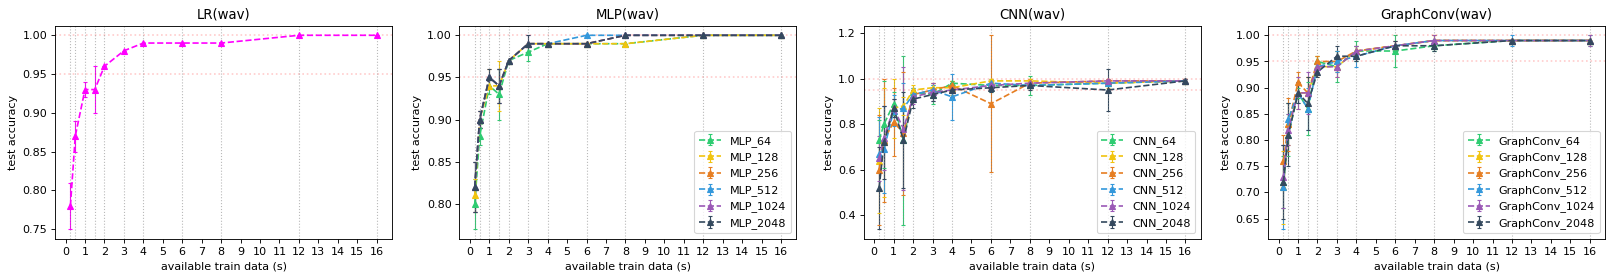

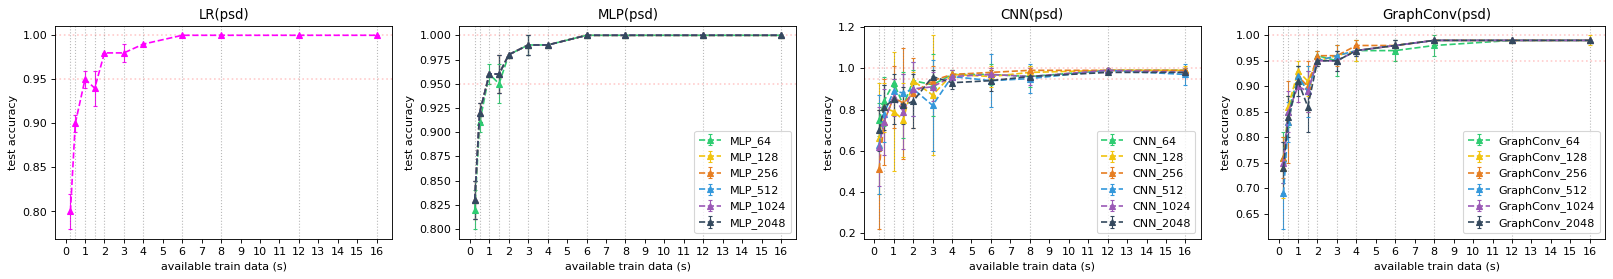

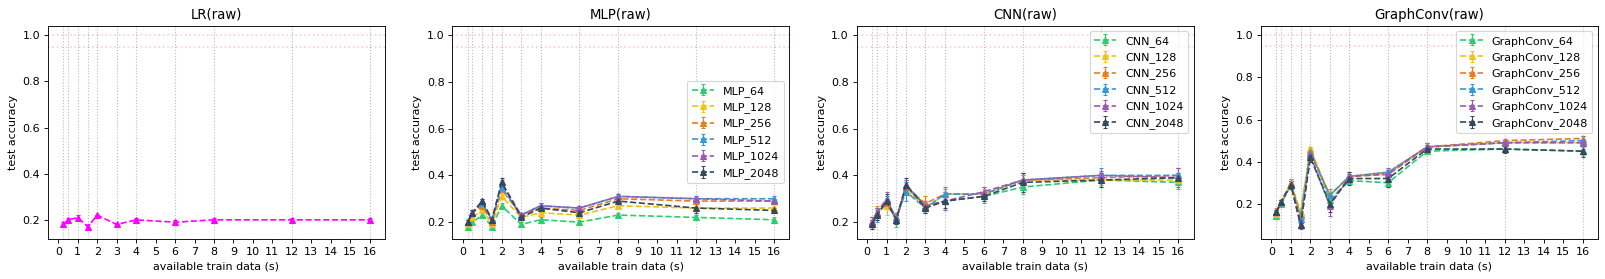

In [254]:
from matplotlib.pyplot import figure
colors = ['#2ecc71','#f1c40f','#e67e22','#3498db','#9b59b6','#34495e']
for i, best_conf_df in enumerate(best_conf_dfs):
    figure(figsize=(25, 12), dpi=80)
    # plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.2, hspace=0)
    for j, name in enumerate(model_names):
        if name =='LR':
            plt.subplot(3, 4, 1 + i*4)
            show_inflection_point_graph(name, best_conf_df, f'{name}({features[i]})')
#             plt.subplot(4, 1, 5)
#             show_inflection_point_graph(name, merged_df, f'{name} ({features[i]}) merged')
            continue
        for k, hc in enumerate(hidden_channels):
            plt.subplot(3, 4, 1+j + i*4, label='k')
            show_inflection_point_graph(f'{name}_{hc}', best_conf_df, f'{name}({features[i]})',show_grid = True if k ==0 else False,color=colors[k],label=f'{name}_{hc}')
            plt.legend()
#             plt.subplot(4, 1, 5+j)
#             show_inflection_point_graph(f'{name}_{hc}', merged_df, f'{name} ({features[i]}) merged',show_grid = True if k ==0 else False,color=colors[k],label=f'{name}_{hc}')
#             plt.legend()
#     plt.show()
plt.savefig(f'figures/results_plot.png')

### Get min amount of data required to train each model for 99% test acc and 95% test acc. Also get highest score with 1 train sample

In [255]:
model_names

['LR', 'MLP', 'CNN', 'GraphConv']

In [261]:
def get_min_amount(row):
    accs = np.array([float(r.split('±')[0]) for r in row.to_numpy()])
    acc_95s_indices = np.where(accs>=.95)[0]
    acc_95 = '-'
    if len(acc_95s_indices)>0:
        idx = acc_95s_indices[0]
        acc_95 = row[idx] +' '+ row.index[idx]
    acc_99s_indices = np.where(accs>=.99)[0]
    acc_99 = '-'
    if len(acc_99s_indices)>0:
        idx = acc_99s_indices[0]
        acc_99 = row[idx] +' '+ row.index[idx]
    return acc_95, acc_99
        

In [263]:
indices = np.zeros(len(hidden_channels)*3+1).astype('str')
results = np.zeros(len(hidden_channels)*3+1).astype('object')
for i, best_conf_df in enumerate(best_conf_dfs):
    # plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.2, hspace=0)
    for j, name in enumerate(model_names):
        if name =='LR':
            acc_95, acc_99 = get_min_amount(best_conf_df.loc[name])
            if name not in indices:
                indices[0] = name
                results[0] = [acc_95, acc_99]
            else:
                _acc_95, _acc_99 = results[0][0],results[0][1]
                if _acc_95.split('±')[0] < acc_95.split('±')[0]:
                    results[0][0] = acc_95
                if _acc_99.split('±')[0] < acc_99.split('±')[0]:
                    results[0][1] = acc_99
            continue
        for k, hc in enumerate(hidden_channels):
            name_hc = f'{name}_{hc}'
            idx = (j-1) * len(hidden_channels) + 1 + k
            acc_95, acc_99 = get_min_amount(best_conf_df.loc[name_hc])
            if name_hc not in indices:
                indices[idx] = name_hc
                results[idx] = [acc_95, acc_99]
            else:
                _acc_95, _acc_99 = results[0][0],results[0][1]
                if _acc_95.split('±')[0] < acc_95.split('±')[0]:
                    results[idx][0] = acc_95
                if _acc_99.split('±')[0] < acc_99.split('±')[0]:
                    results[idx][1] = acc_99
#     break    

In [269]:
nine_fives = [x[0] for x in results]
nine_nines = [x[1] for x in results]

In [271]:
df = pd.DataFrame(
{"95" : nine_fives,
"99" : nine_nines},
index = best_conf_dfs[0].index)

In [272]:
df

,95,99
LR,0.96±0.00 wav 2.0 s.,0.99±0.00 psd 4.0 s.
MLP_64,0.97±0.00 wav 2.0 s.,0.99±0.01 psd 3.0 s.
MLP_128,0.97±0.00 wav 2.0 s.,0.99±0.01 psd 3.0 s.
MLP_256,0.96±0.00 psd 1.0 s.,0.99±0.00 psd 3.0 s.
MLP_512,0.96±0.00 psd 1.0 s.,0.99±0.01 psd 3.0 s.
MLP_1024,0.96±0.00 psd 1.0 s.,0.99±0.01 psd 3.0 s.
MLP_2048,0.96±0.00 psd 1.0 s.,0.99±0.01 psd 3.0 s.
CNN_64,0.98±0.01 wav 4.0 s.,0.99±0.00 psd 12.0 s.
CNN_128,0.97±0.02 psd 4.0 s.,0.99±0.01 psd 12.0 s.
CNN_256,0.97±0.02 psd 4.0 s.,0.99±0.01 psd 8.0 s.
